# Section 1 - Quantifying the association of a feature with an outcome

* We frequently want to know if a **feature** is **associated** with an **outcome**. For example, we might want to determine:
    * Is the presence of a specific cell stress condition (feature) associated with the formation of stress granules (outcome)?
    * Is the amino acid sequence of a protein (feature) associated with its propensity to misfold (outcome)?
* This type of analysis is invaluable for checking for correlations between features and outcomes in complex data
* In this section we will explore using contingency tables, odds ratios, and Fisher's Exact Test to test for association

## Example 1.1

**Application 1.1**: We hypothesize that *E. coli* proteins that contain native entanglements are more likely to misfold than proteins without entanglements.

* To proceed, we need information about which proteins in *E. coli* contain entanglements and which proteins in *E. coli* misfold. 

### What is an entanglement? How can we tell if a protein is entangled?

* Entanglements are a structural motif in proteins formed by two segments: a loop (closed by a native contact) and a thread (**Figures 1.1.1** & **1.1.2**).

![](../images/entanglement-2D.png)

**Figure 1.1.1**. *General structure of a non-covalent lasso entanglement. The threading segment (blue) passes through a loop (red) that is closed by a native contact (yellow). J. Mol. Biol. 436 (2024) 168487.*

![](../images/native-and-entangled-states.png)

**Figure 1.1.2**. *3D structures of oligoribonuclease without (left) and with (right) an entanglement. The threading segment (blue) passes through a loop (red) that is closed by a native contact (yellow). J. Mol. Biol. 436 (2024) 168487.*

* Some proteins contain entanglements in their native state (*i.e.*, native entanglements)
  
* Some proteins can gain or lose entanglements during misfolding

* For the current hypothesis, we are concerned with native entanglements; this information can be obtained by analyzing either experimental structures or predicted structures

* Our analysis will use data on entanglements computed from experimental structures of *E. coli* proteins

### How can we tell if a protein misfolds?

* The structural proteomics technique *limited proteolysis mass spectrometry* (LiP-MS) profiles changes in protein structures across the proteome in response to perturbations (**Figure 1.1.3**)

![](../images/lip-ms.png)

**Figure 1.1.3**. *Schematic of a LiP-MS experiment. When studying misfolding, one sample will be treated with guanidinium chloride to induce unfolding before a dilution jump is used to stimulate refolding; the other sample is not treated with guanidinium chloride, preserving protein native states. Nature Protocols volume 12, p. 2391–2410 (2017).*

* LiP-MS compares differences in protein structures between two samples

* In the case at hand, a protein is considered to misfold if there is a significant change in its limited proteolysis digestion pattern between a guanidinium chloride-unfolded/refolded and an untreated sample containing natively folded protein

* We will use LiP-MS data from *E. coli* to match the *E. coli* entanglement data

### We have our data - what now?

* Now that we have identified relevant data to test our hypothesis, let's dive into some code. 

## Testing our hypothesis in Python

### Step 0 - Load libraries

* We first need to make sure we have access to all of the functions etc. that we need for this analysis - let's load some libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt

### Step 1 - Load the data
* After loading the libraries, we now need to load the data into memory

In [2]:
# "data1" is a pandas DataFrame object
data_path = "/home/jovyan/data-store/data/iplant/home/shared/NCEMS/BPS-training-2025/"
data1     = pd.read_csv(data_path + "NativeEntanglements_and_SigCuts_EXP_buffC.csv")

### Step 2 - Explore the data

* Let's explore the data quickly to get a better understanding of what we need to do

In [3]:
# first, print a quick summary
print ("Create a quick summary of the DataFrame:\n")
data1.info()

# second, print the first 10 rows of data1
print ("\nPrint the first 10 rows of the DataFrame:\n")
display(data1.head(10))

# third, count the number of unique gene identifiers in column "gene" of data1
print ("\nThe number of unique genes is:", len(data1["gene"].unique()))

Create a quick summary of the DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   buff           345 non-null    object
 1   gene           345 non-null    object
 2   NativeEnt      345 non-null    bool  
 3   NonRefoldable  345 non-null    bool  
dtypes: bool(2), object(2)
memory usage: 6.2+ KB

Print the first 10 rows of the DataFrame:



,buff,gene,NativeEnt,NonRefoldable
0,C,P00350,True,True
1,C,P00370,True,True
2,C,P00448,True,True
3,C,P00509,True,True
4,C,P00561,True,False
5,C,P00579,False,False
6,C,P00864,True,True
7,C,P00934,True,True
8,C,P00954,False,True
9,C,P00957,True,True



The number of unique genes is: 345


* We can see from this summary that this data file contains 4 columns:
    * `buff`: the buffer condition for the experiment
    * `gene`: the unique gene identifier (there are no duplicates!)
    * `NativeEnt`: `True` if the protein has a native entanglement, `False` if it does not
    * `NonRefoldable`: `True` if the protein *did not* refold in LiP-MS experiment (i.e., misfolded), `False` if it *did* refold
<pre>

</pre>
* Now that we have a better understanding of the data, we are ready to run our analysis.

### Step 3 - Run the analysis

This is our contingency table:



<Figure size 640x480 with 0 Axes>

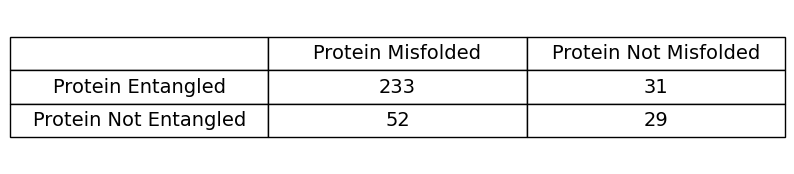

In [4]:
# compute the values of {a, b, c, d} and construct the contingency table
a = len(data1[(data1["NativeEnt"] == True ) & (data1["NonRefoldable"] == True )])
b = len(data1[(data1["NativeEnt"] == True ) & (data1["NonRefoldable"] == False)])
c = len(data1[(data1["NativeEnt"] == False) & (data1["NonRefoldable"] == True )])
d = len(data1[(data1["NativeEnt"] == False) & (data1["NonRefoldable"] == False)])

# put values into a new format to enable a nice print statement & analysis
contingency_table = pd.DataFrame({"Protein Misfolded"    : [a, c], 
                                  "Protein Not Misfolded": [b, d]},
                                 index = ["Protein Entangled", "Protein Not Entangled"])

# print the output
print ("This is our contingency table:\n")

# create a table from our contingency_table using matplotlib
plt.clf()
fig, ax    = plt.subplots(figsize = (5, 2))
ax.axis("tight")
ax.axis("off")
cell_text  = contingency_table.reset_index().values.tolist()
col_labels = [""] + contingency_table.columns.tolist()
table      = ax.table(cellText=cell_text, colLabels=col_labels, loc="center", cellLoc="center")
table.auto_set_font_size(False)
table.set_fontsize(14)  
table.scale(2, 2)  
plt.show()

* We can complete this analysis by computing the odds ratio and *p*-value

In [5]:
# use the fisher_exact function from scipy.stats to compute the odds ratio and p-value
odds_ratio, fisher_p_value = fisher_exact(contingency_table, alternative = "two-sided")

# print the results of this analysis
print ("The odds ratio is:", "%.2f" %odds_ratio)
print ("The p-value is   :", "%.2e" %fisher_p_value)

The odds ratio is: 4.19
The p-value is   : 2.93e-06


### Step 4 - Interpret the results

* The odds ratio of 4.19 indicates that there is a **positive association** between entanglement and misfolding
* In other words, entanglement and misfolding tend to co-occur in the same protein, supporting our hypothesis
    * Odds ratios > 1 indicate positive association
    * Odds ratios = 1 indicate no association
    * Odds ratios < 1 indicate negative association
* We can also say that the **odds** of an entangled protein misfolding are 4.19 times greater than the odds of a non-entangled protein misfolding
* The *p*-value is <<0.05, which is a common threshold for significance; in this instance, we conclude the result is significant